In [82]:
import time
import pandas as pd 
import numpy as np
import pingouin as pg 
import lightgbm as lgb 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import seaborn as sns

In [73]:
df = pd.read_csv('fixed_projects.csv')

In [74]:
replace_values = {'Illicit':1, 'likely-reputable':0}
# replace_values = {1:'Illicit', 0:'likely-reputable'}
df['FLAG'] = df['FLAG'].replace(replace_values)

In [75]:
X = df.drop(columns = ['Address', 'FLAG'], axis=1)
y = df['FLAG']

### Inferential Statistics

In [76]:
# Correlation between inputs 
corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

X.drop(columns=to_drop, axis=1, inplace=True)

/tmp/ipykernel_4131/4228884520.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


### Model Training

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)

In [78]:
def stratified_k_fold_LGBM(X, Y, n_folds):
    # import matplotlib
    # matplotlib.use('Agg')
    print("Starting stratified Cross-validation using LGBM")
    #model1 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
    #                           subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
    #                           scale_pos_weight=1, seed=27)
    clf = lgb.LGBMClassifier(learning_rate=0.2)
    max_depth = [2, 3, 4, 5, 6, 7, 8]
    n_estimators = [100, 150, 200, 250, 300]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=7)
    score = {'f1', 'roc_auc', 'accuracy'}
    current = time.time()
    #results = cross_validate(model1, X, Y, cv=kfold, scoring=scoring, return_train_score=True, n_jobs=-1)
    results = GridSearchCV(clf,param_grid, cv=kfold, scoring='roc_auc', n_jobs=6)
    grid_result = results.fit(X, Y)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print("Execution time: ", time.time() - current)

    # plot results
    scores = np.array(means).reshape(len(max_depth), len(n_estimators))
    for i, value in enumerate(max_depth):
        plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.show()

Starting stratified Cross-validation using LGBM
Best: 0.999999 using {'max_depth': 2, 'n_estimators': 100}
0.999999 (0.000003) with: {'max_depth': 2, 'n_estimators': 100}
0.999999 (0.000003) with: {'max_depth': 2, 'n_estimators': 150}
0.999998 (0.000007) with: {'max_depth': 2, 'n_estimators': 200}
0.999998 (0.000007) with: {'max_depth': 2, 'n_estimators': 250}
0.999998 (0.000007) with: {'max_depth': 2, 'n_estimators': 300}
0.999995 (0.000014) with: {'max_depth': 3, 'n_estimators': 100}
0.999995 (0.000014) with: {'max_depth': 3, 'n_estimators': 150}
0.999997 (0.000010) with: {'max_depth': 3, 'n_estimators': 200}
0.999997 (0.000010) with: {'max_depth': 3, 'n_estimators': 250}
0.999997 (0.000010) with: {'max_depth': 3, 'n_estimators': 300}
0.999997 (0.000010) with: {'max_depth': 4, 'n_estimators': 100}
0.999997 (0.000010) with: {'max_depth': 4, 'n_estimators': 150}
0.999995 (0.000014) with: {'max_depth': 4, 'n_estimators': 200}
0.999997 (0.000010) with: {'max_depth': 4, 'n_estimators': 25

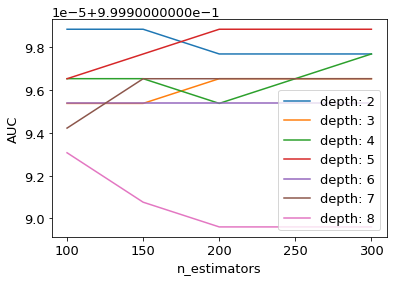

In [79]:
stratified_k_fold_LGBM(X, y, 10)

/home/malik_cyrus/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/malik_cyrus/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_error: 0.348109	training's binary_logloss: 0.562378	valid_1's binary_error: 0.367623	valid_1's binary_logloss: 0.572668
[2]	training's binary_error: 0.348109	training's binary_logloss: 0.494629	valid_1's binary_error: 0.367623	valid_1's binary_logloss: 0.503891
[3]	training's binary_error: 0.0264563	training's binary_logloss: 0.438315	valid_1's binary_error: 0.0303194	valid_1's binary_logloss: 0.446426
[4]	training's binary_error: 0.0106753	training's binary_logloss: 0.389938	valid_1's binary_error: 0.0140769	valid_1's binary_logloss: 0.396988
[5]	training's binary_error: 0.00719424	training's binary_logloss: 0.348691	valid_1's binary_error: 0.00920411	valid_1's binary_logloss: 0.354863
[6]	training's binary_error: 0.00232072	training's binary_logloss: 0.312704	valid_1's binary_error: 0.00433135	valid_1's binary_logloss: 0.318355
[7]	training's binary_error: 0.00232072	training's binary_logloss: 0.281456	valid_1's binary_error: 0.00433135	valid_1's binary_logloss:

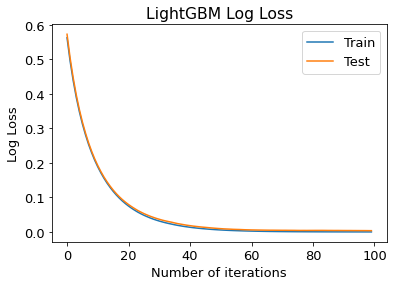

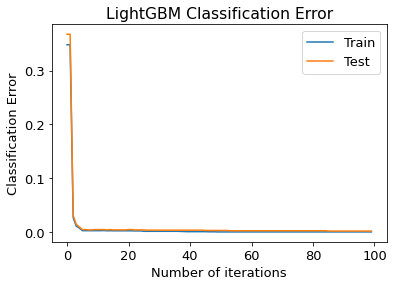

In [80]:
clf = lgb.LGBMClassifier(learning_rate=0.09,
                            max_depth=8,
                            subsample=0.5, 
                            objective='binary',
                            n_estimators=100)
eval_set = [(X_train, y_train), (X_test, y_test)]
# clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["error", "logloss"],
#           eval_set=eval_set, verbose=True)
clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["error", "logloss"],
              eval_set=eval_set, verbose=True)

# predict
y_pred = clf.predict(X_test)
predicted_values = [round(val) for val in y_pred]

# evaluation 
accuracy = accuracy_score(y_test, predicted_values)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# performance metrics 
results = clf.evals_result_
epochs = len(results['training']['binary_error'])
x_axis = range(0, epochs)
plt.rcParams.update({'font.size': 13})

# plotting log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['training']['binary_logloss'], label='Train')
ax.plot(x_axis, results['valid_1']['binary_logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Number of iterations')
plt.title('LightGBM Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['training']['binary_error'], label='Train')
ax.plot(x_axis, results['valid_1']['binary_error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.xlabel('Number of iterations')
plt.title('LightGBM Classification Error')
plt.show()

### Confusion Matrix

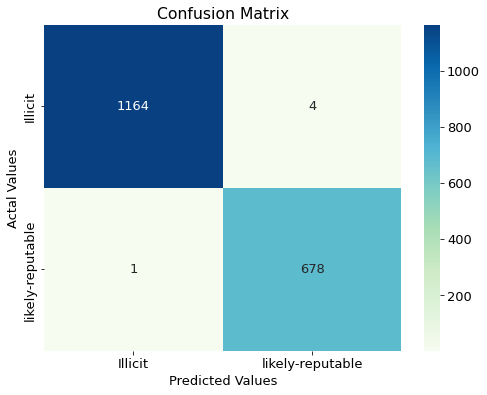

In [83]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Illicit', 'likely-reputable'], 
                     columns = ['Illicit', 'likely-reputable'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='GnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Random Forest Classifier

In [84]:

rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)
pred8 = rfc_model.predict(X_test)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(y_test, pred8) * 100))
print(classification_report(y_test, pred8, digits=4))
roc = roc_auc_score(y_test, rfc_model.predict_proba(X_test)[:, 1])
print("ROC:" , roc)

Accuracy for Random Forest Model: 99.84
              precision    recall  f1-score   support

           0     0.9991    0.9983    0.9987      1168
           1     0.9971    0.9985    0.9978       679

    accuracy                         0.9984      1847
   macro avg     0.9981    0.9984    0.9983      1847
weighted avg     0.9984    0.9984    0.9984      1847

ROC: 0.9999974781608731


### Logistic Regression for Classification

In [67]:
#  normalizing data set 
X_train_reg = StandardScaler().fit_transform(X_train)
X_test_reg = StandardScaler().fit_transform(X_test)


In [69]:
lgr = LogisticRegression(max_iter=100000)
lgr.fit(X_train, y_train)

y_pred = lgr.predict(X_test)
print("Accuracy of logistic regression classifier on test set: {:.2f}".format(accuracy_score(y_test, y_pred)))

Accuracy of logistic regression classifier on test set: 0.98


In [70]:
cfm = confusion_matrix(y_test, y_pred)
print(cfm)

[[1165   26]
 [   3  653]]


In [71]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9974    0.9782    0.9877      1191
           1     0.9617    0.9954    0.9783       656

    accuracy                         0.9843      1847
   macro avg     0.9796    0.9868    0.9830      1847
weighted avg     0.9847    0.9843    0.9844      1847



### Predict Probability using LGBM